In [1]:
from standardInclude import *

Welcome to JupyROOT 6.20/04
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [90]:
#path = "/home/jlab/g-2/caloTrackMatching/data/run2c/"; dataset='Run 2C'
path = "/home/jlab/g-2/caloTrackMatching/data/endgame/"; dataset='EndGame'
files = os.listdir(path)
print(files)
names = [x.split("_")[0] for x in files]
print(names)

fs = {}
for file in files:
    name = file.split("_")[0]
    fs[name] = r.TFile(path+file)
    fs[name].ls()

['clusters_eg.root', 'tracks_eg.root', 'matchedTracks_eg.root']
['clusters', 'tracks', 'matchedTracks']
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters
TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRadialFieldRand;1	Tracker 

In [91]:
allFitResults = {}

In [92]:
station = 12
calo = station+1

---

### First create a function which will act as a standard pool from which we can pull our fit functions, just for ease of switching between them

In [131]:
def fitfunc(choice, fitrange, params=None):
    tlow, thigh = fitrange
    if(choice is 0):
        func = r.TF1("func","[0] + [1] - [1]/(TMath::Exp([2]*x)) + [3]*(x)",tlow,thigh)
        func.SetParNames("C", "A", "#tau", "m")
        if(params is None):
            paramVec = [1,10,1,-0.0001,10]
        else:
            paramVec = params
        for i,xi in enumerate(paramVec):
            func.SetParameter(i,xi)
        return (func,paramVec)
    elif(choice is 1):
        func = r.TF1("func","pol1",tlow,thigh)
        func.SetParNames("C", "m")
        if(params is None):
            params = [1,-0.00001]
        for i,xi in enumerate(params):
            func.SetParameter(i,xi)
        return (func, params)
    else:
        print("Invalid choice")
        return -1

---

# Lets start with the tracker-only information


In [132]:
name = 'tracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/tracks_eg.root	
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x55f6700192e0
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x55f66eab2d10
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55f66e97b280
  OBJ: TH3I	trackerCaloPos_noRadialFieldRand	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55f671388580
  KEY: TH3I	trackerBeamPos;1	Tracker Beam Position vs. Time
  KEY: TH3I	trackerCaloPos;1	Tracker Calo Face Position vs. Time
  KEY: TH3I	trackerBeamPosRand;1	Tracker Beam Position vs. Rand Time
  KEY: TH3I	trackerCaloPosRand;1	Tracker Calo Face Position vs. Rand Time
  KEY: TH3I	trackerCaloPos_noRadialField;1	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time
  KEY: TH3I	trackerCaloPos_noRad

In [133]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

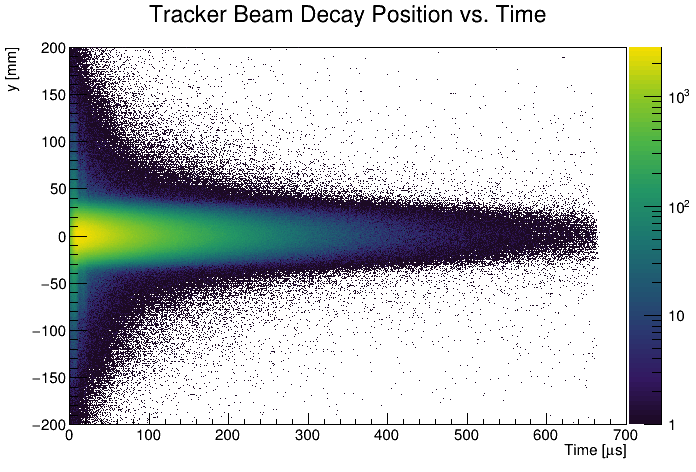

In [134]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time; Time [#mus]; y [mm]")
hi.Draw("colz")
c.SetLogz()
c.Draw()

---

### Lets get the beam position vs. time for the selected station

In [145]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [194]:
tlow = 30
thigh = 500
func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'],nFit=2)
allFitResults[name+"_beam"] = fitresult

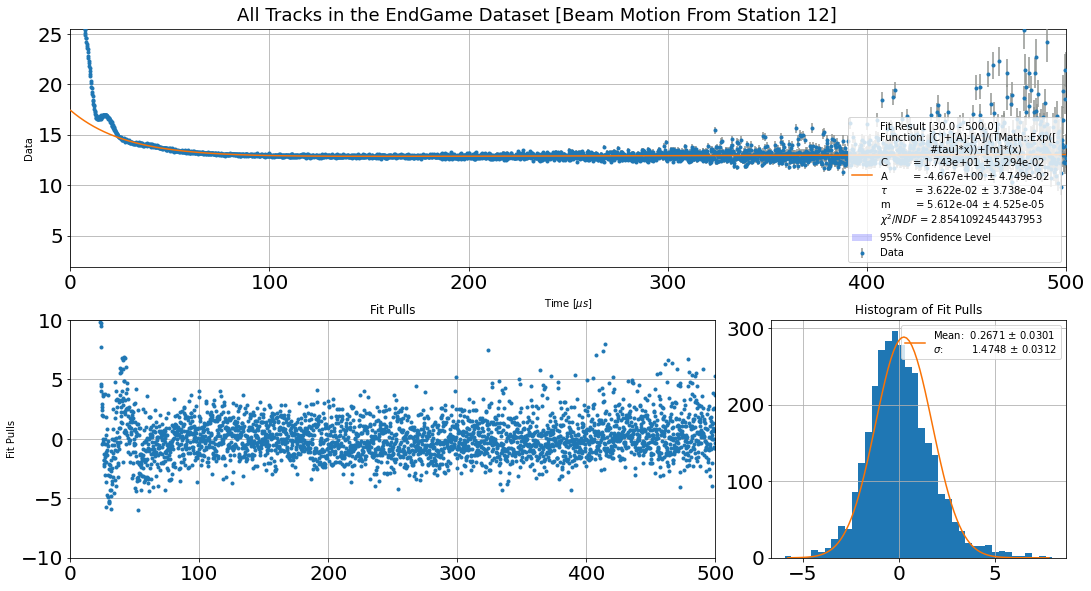

In [195]:
#fitresult.f.SetParameters(15,-170,0.00053,0.061)

fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(11,15)
for i in range(2):
    ax[i].set_xlim(0,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

/home/jlab/g-2/fitting/python_fit.py:414: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


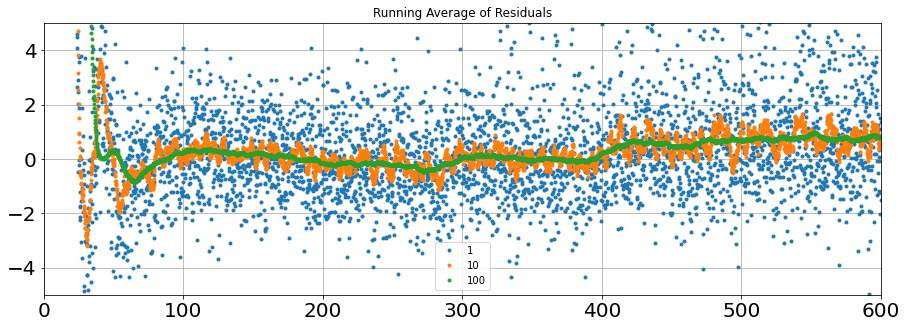

In [196]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(0,600)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [60, 300]


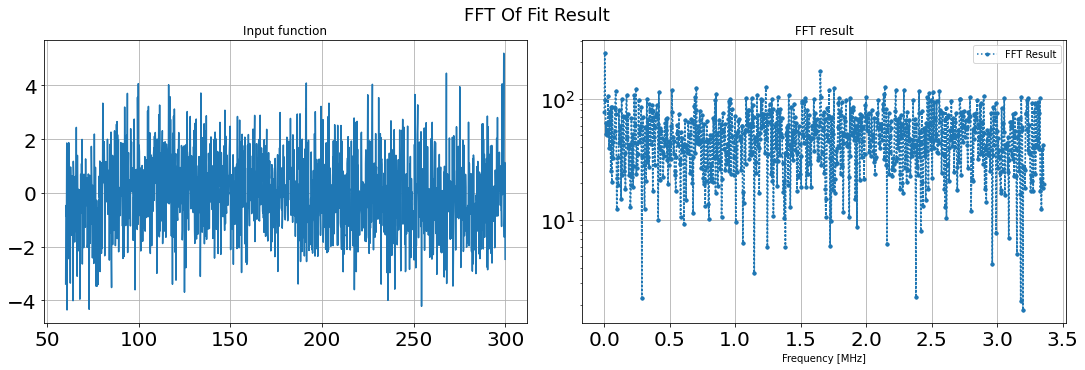

(array([ 0.        ,  0.00416859,  0.00833718, ..., -0.01250577,
        -0.00833718, -0.00416859]),
 array([ -77.15340228+0.00000000e+00j, -116.35316579-2.06637350e+02j,
         -97.34270788-4.50171226e+00j, ...,  -51.48992073-6.98586719e-02j,
         -97.34270788+4.50171226e+00j, -116.35316579+2.06637350e+02j]))

In [199]:
fitresult.fft([60,300],2)

---

### And the calo face position vs. time for the selected station

In [200]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

In [203]:
tlow = 30
thigh = 500
func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

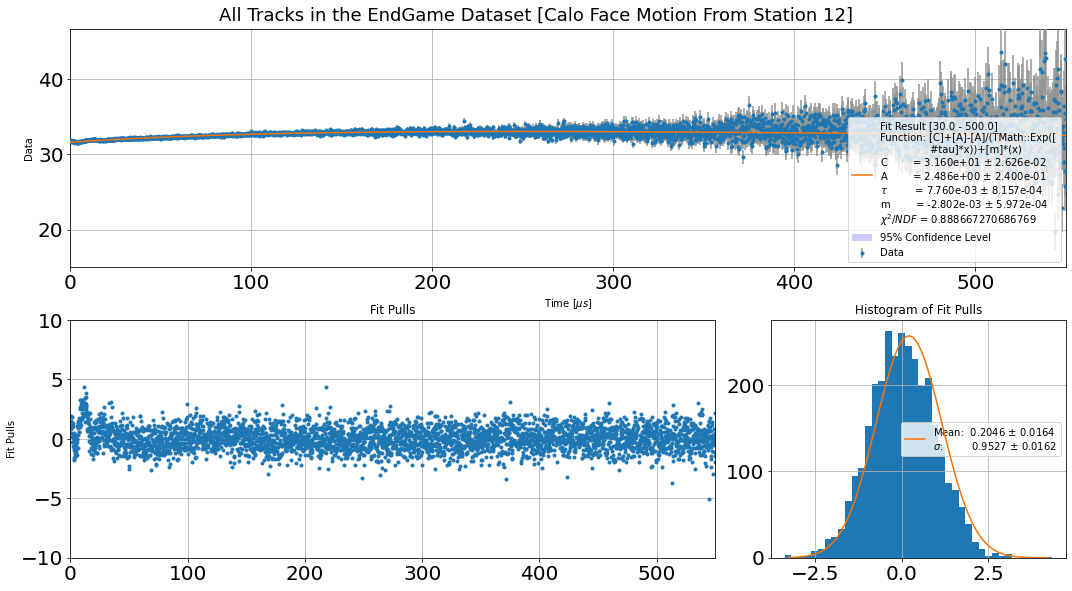

In [204]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Station "+str(station)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(30,35)
for i in range(2):
    ax[i].set_xlim(0,550)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

/home/jlab/g-2/fitting/python_fit.py:414: RuntimeWarning: Mean of empty slice
  mean_ri = np.nanmean(resid[i-runningAverage:i+runningAverage])


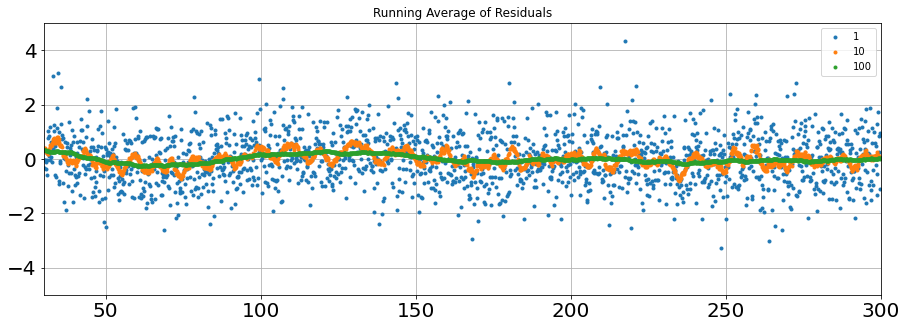

In [205]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


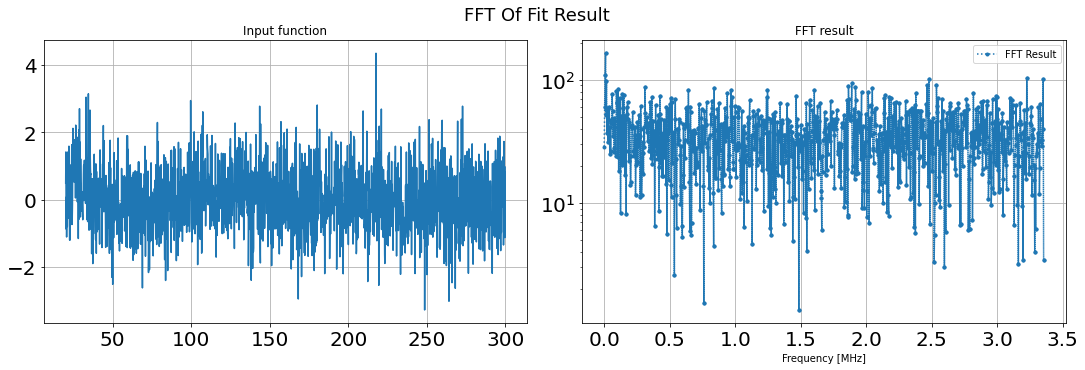

(array([ 0.        ,  0.00357181,  0.00714362, ..., -0.01071543,
        -0.00714362, -0.00357181]),
 array([ 28.60897919-7.10542736e-15j, -20.62829073-5.68953050e+01j,
         77.68587005+7.62050786e+01j, ..., 152.66672037+6.12580114e+01j,
         77.68587005-7.62050786e+01j, -20.62829073+5.68953050e+01j]))

In [206]:
fitresult.fft([20,300],2)

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [209]:
trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

In [210]:
tlow = 30
thigh = 600

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo_noRadialField"] = fitresult

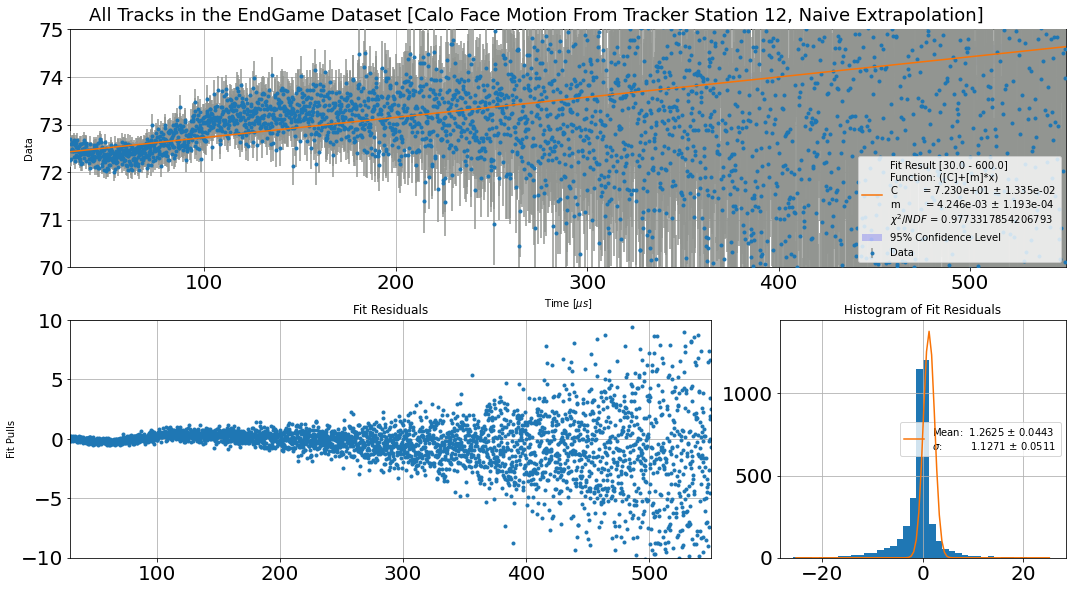

In [212]:
fig,ax = fitresult.draw("All Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(30,550)
ax[0].set_ylim(70,75)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

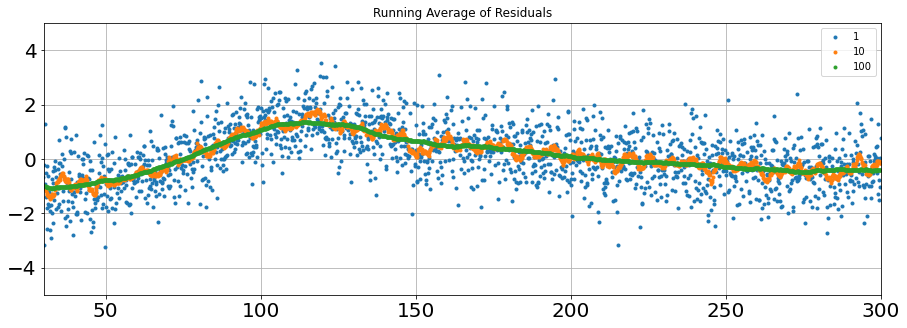

In [21]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [20, 300]


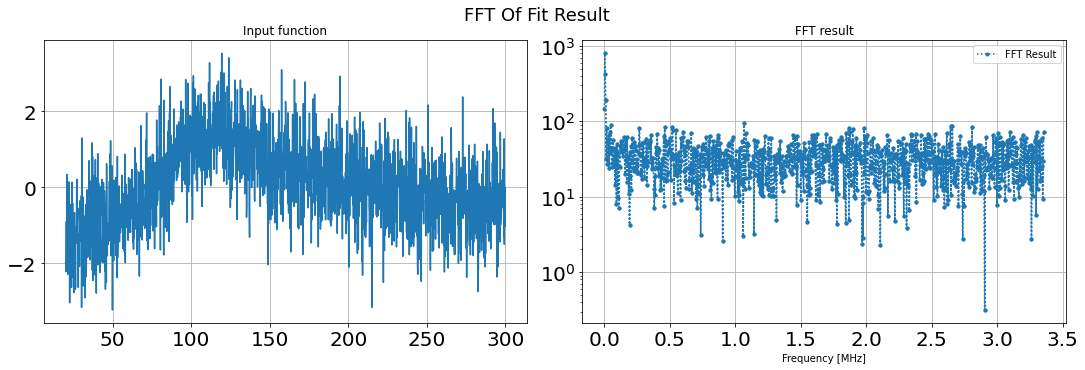

(array([ 0.        ,  0.00357181,  0.00714362, ..., -0.01071543,
        -0.00714362, -0.00357181]),
 array([ 147.36743052+1.59872116e-14j, -730.99066886-3.25579383e+02j,
        -202.20923704+3.67304118e+02j, ...,  135.69008066-1.34662323e+02j,
        -202.20923704-3.67304118e+02j, -730.99066886+3.25579383e+02j]))

In [22]:
fitresult.fft([20,300],2)

---

# And now the calo only information

In [213]:
name = 'clusters'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/clusters_eg.root	
  KEY: TH3F	clusters13;1	clusters
  KEY: TH3F	randclusters13;1	time randomized clusters
  KEY: TH3F	clusters19;1	clusters
  KEY: TH3F	randclusters19;1	time randomized clusters


In [214]:
clusters = f.Get("clusters"+str(calo)).Clone()
randclusters = f.Get("randclusters"+str(calo)).Clone()

---
### Calo face position

In [215]:
randclusters.GetYaxis().SetRange(randclusters.GetYaxis().FindBin(1000),randclusters.GetYaxis().FindBin(2400))
widthDict = getWidths(randclusters.Project3D("zx"), scale=25, offset=3)

In [225]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(1, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

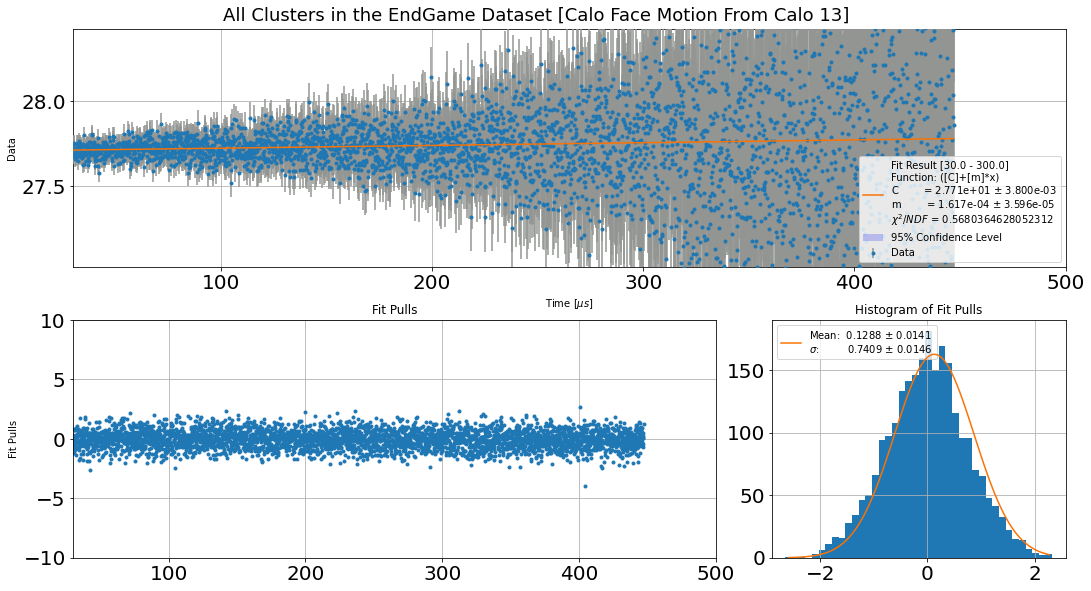

In [226]:
fig,ax = fitresult.draw("All Clusters in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(30,500)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

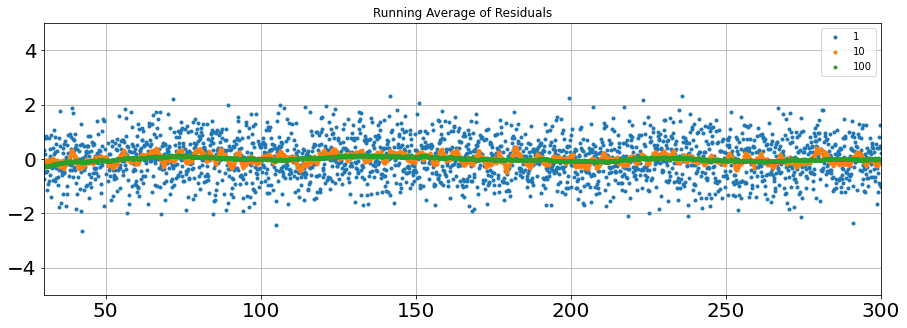

In [227]:
fig,ax = plt.subplots(figsize=(15,5))
fitresult.plotResiduals(ax, 1, ".", "1", 1)
fitresult.plotResiduals(ax, 1, ".", "10", 10)
fitresult.plotResiduals(ax, 1, ".", "100", 100)
plt.xlim(30,300)
plt.ylim(-5,5)
plt.grid()
plt.title("Running Average of Residuals")
plt.legend()
plt.show()

Restricting range of FFT to: [30, 300]


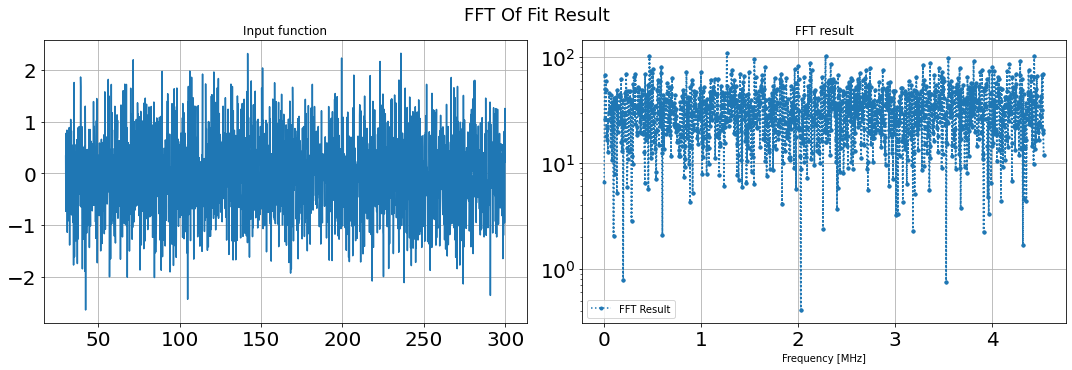

(array([ 0.        ,  0.0037032 ,  0.00740639, ..., -0.01110959,
        -0.00740639, -0.0037032 ]),
 array([ -6.68445356+7.10542736e-15j, -36.29929674-5.71145407e+01j,
        -16.16618356+2.04878837e+01j, ..., -28.88706677+4.13064972e+01j,
        -16.16618356-2.04878837e+01j, -36.29929674+5.71145407e+01j]))

In [228]:
fitresult.fft([30,300],2)

---

# And finally the calo-matched information

In [229]:
name = 'matchedTracks'
f = fs[name]
f.ls()

TFile**		/home/jlab/g-2/caloTrackMatching/data/endgame/matchedTracks_eg.root	
 TFile*		/home/jlab/g-2/caloTrackMatching/data/endgame/matchedTracks_eg.root	
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55f66f43e290
  OBJ: TH1D		Tracker Beam Position vs. Rand Time yx projection : 0 at: 0x55f66eace070
  OBJ: TH2D	trackerCaloPosRand_yx	Tracker Calo Face Position vs. Rand Time yx projection : 0 at: 0x55f6708fe5d0
  OBJ: TH3I	trackerBeamPosRand	Tracker Beam Position vs. Rand Time : 0 at: 0x55f66ff46770
  OBJ: TH3I	trackerCaloPosRand	Tracker Calo Face Position vs. Rand Time : 0 at: 0x55f66eab3680
  OBJ: TH3I	trackerCaloPos_noRadialField	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55f66ea8dbe0
  OBJ: TH3I	trackerCaloPos_noRadialFieldRand	Tracker Calo Face Position [Straight Line Extrapolation] vs. Time : 0 at: 0x55f670018e10
  OBJ: TH2D	trackerBeamPosRand_yx	Tracker Beam Decay Position vs. Time : 0 at: 0x55f670ef7

In [230]:
trackerBeamPos = f.Get("trackerBeamPosRand").Clone()
trackerCaloPos = f.Get("trackerCaloPosRand").Clone()
caloCaloPos = f.Get("caloCaloPosRand").Clone()
trackerCaloPos_noRadialField = f.Get("trackerCaloPos_noRadialField").Clone()
trackerCaloPos_noRadialFieldRand = f.Get("trackerCaloPos_noRadialFieldRand").Clone()

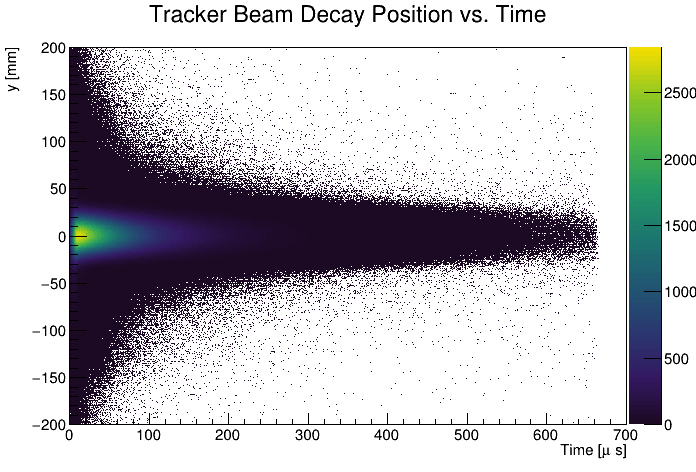

In [231]:
c = r.TCanvas()
#trackerBeamPos.Draw("lego2z")
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))

hi = trackerBeamPos.Project3D("yx").Clone()
hi.SetTitle("Tracker Beam Decay Position vs. Time")
hi.Draw("colz")
c.Draw()

---

### Beam position vs. time

In [232]:
trackerBeamPos.GetZaxis().SetRange(trackerBeamPos.GetZaxis().FindBin(station),trackerBeamPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerBeamPos.Project3D("yx"))

In [237]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[15,-170,0.00053,0.061]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_beam"] = fitresult

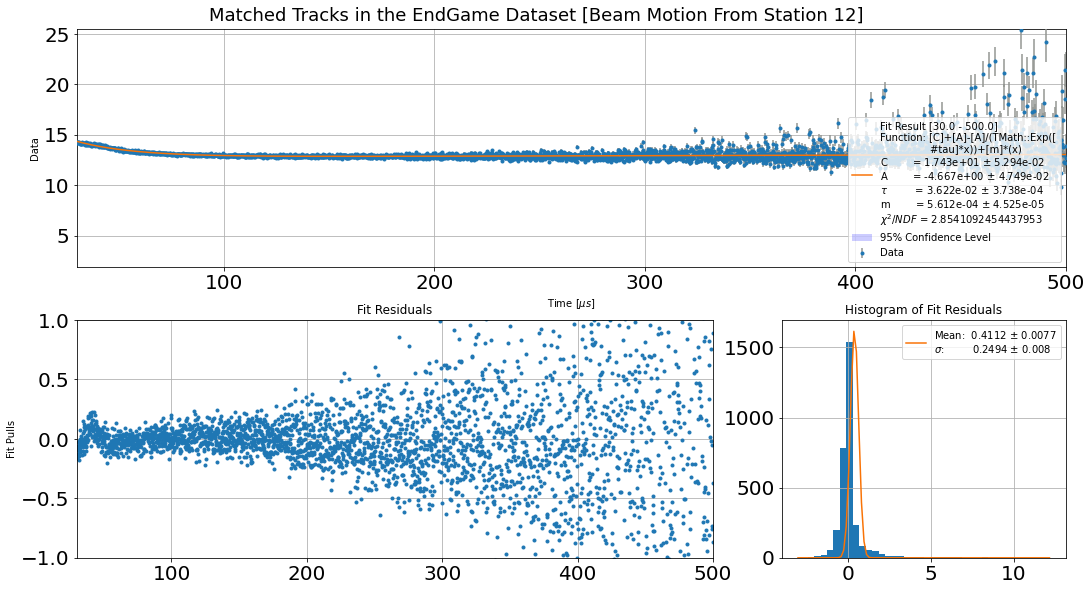

In [242]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Beam Motion From Station "+str(station)+"]", 
                        yrange=[None, [-1,1]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(30,500)
ax[0].set_xlabel(r"Time [$\mu s$]")

plt.show()

---

### Calo face position vs. time (from tracker)

In [243]:
trackerCaloPos.GetZaxis().SetRange(trackerCaloPos.GetZaxis().FindBin(station),trackerCaloPos.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos.Project3D("yx"))

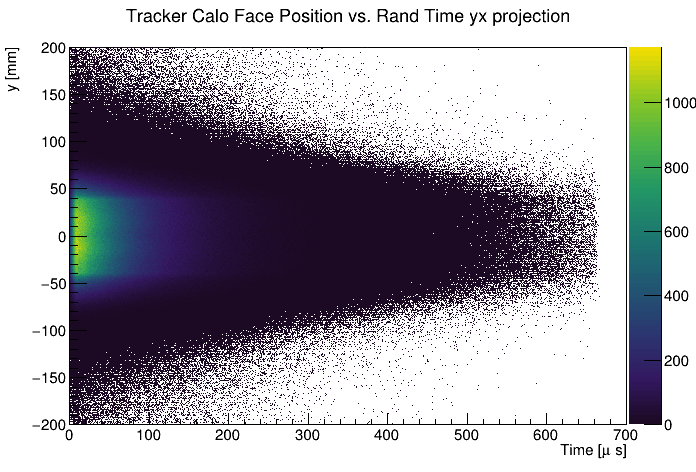

In [244]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos.Project3D("yx").Draw("colz")
trackerCaloPos.SetTitle("Normal Extrapolation to Calo Face")
c.Draw()

In [248]:
tlow = 30
thigh = 500

func,paramVec = fitfunc(0, [tlow,thigh],[32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo"] = fitresult

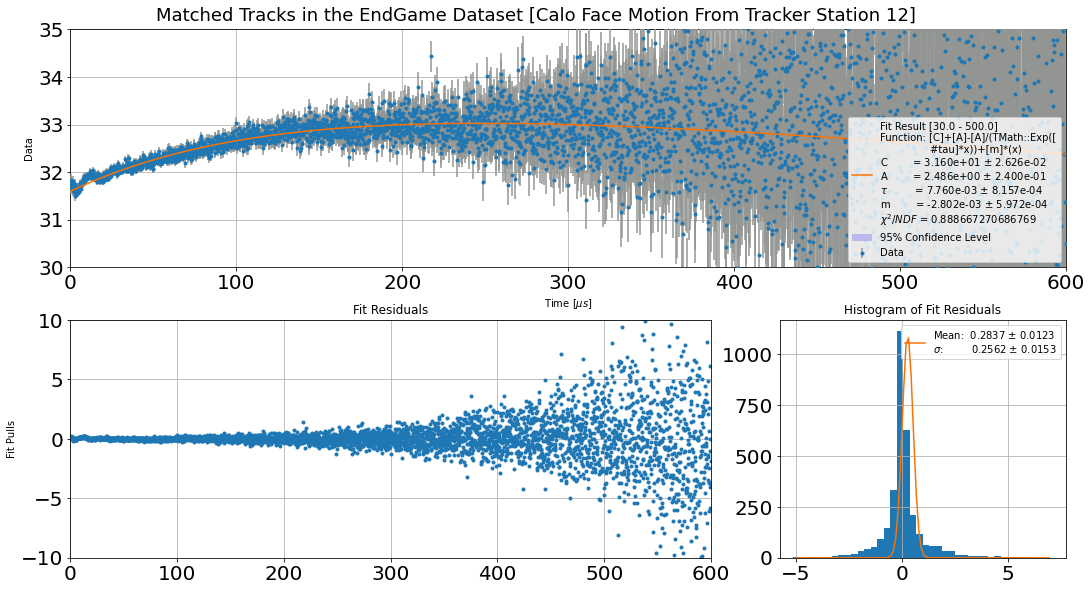

In [250]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Tracker Station "+str(station)+"]", 
                        yrange=[[30,35], [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,600)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

### Calo face position vs. time (from tracker, but ignoring radial field)

In [251]:
trackerCaloPos_noRadialFieldRand.GetZaxis().SetRange(
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station),
    trackerCaloPos_noRadialFieldRand.GetZaxis().FindBin(station))
widthDict = getWidths(trackerCaloPos_noRadialFieldRand.Project3D("yx"))

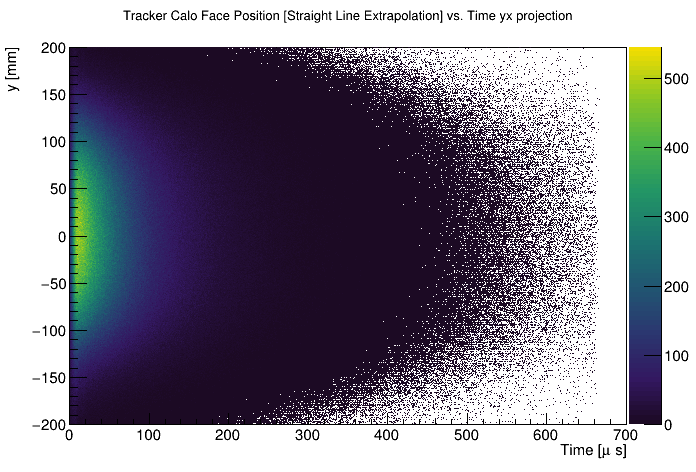

In [252]:
c = r.TCanvas()
#trackerCaloPos_noRadialField.Project3D("yx").Draw("colz")
trackerCaloPos_noRadialFieldRand.Project3D("yx").Draw("colz")
c.Draw()

In [253]:
tlow = 30
thigh = 600

func,paramVec = fitfunc(0, [tlow,thigh], [32, 3.5, 0.0005, -0.005]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_calo_noRadialField"] = fitresult

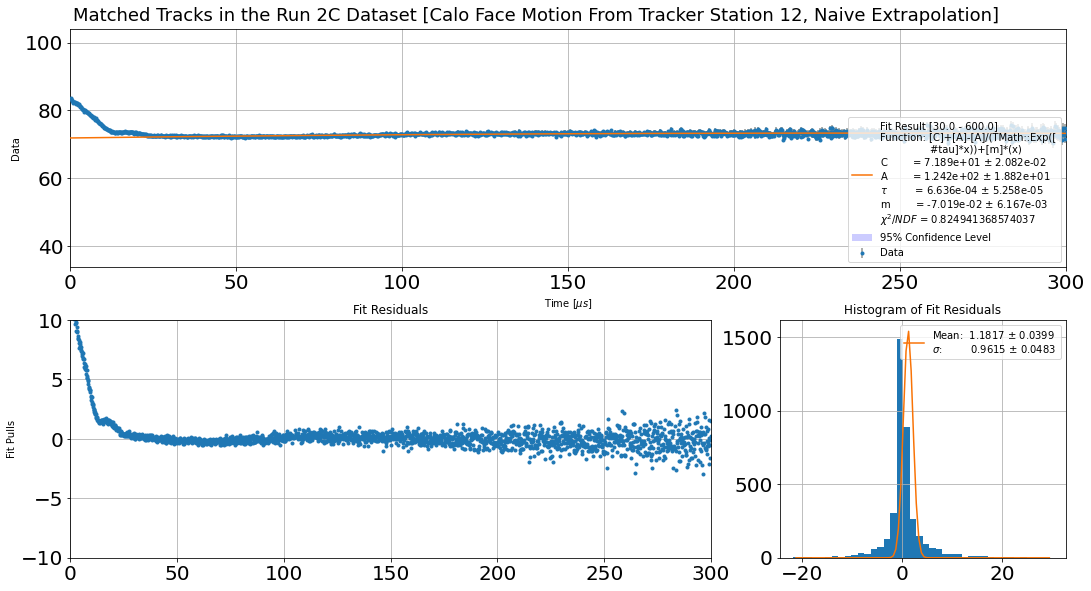

In [254]:
fig,ax = fitresult.draw("Matched Tracks in the Run 2C Dataset [Calo Face Motion From Tracker Station "+str(station)+", Naive Extrapolation]", 
                        yrange=[None, [-10,10]], fmti=".", do_pulls=False)
#ax[0].set_ylim(-2,2)
for i in range(2):
    ax[i].set_xlim(0,300)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

### Calo face position vs. time (from clusters)

In [255]:
caloCaloPos.GetZaxis().SetRange(caloCaloPos.GetZaxis().FindBin(station),caloCaloPos.GetZaxis().FindBin(station))
widthDict = getWidths(caloCaloPos.Project3D("yx"))

In [256]:
tlow = 30
thigh = 300

func,paramVec = fitfunc(0, [tlow,thigh]) 

fitresult = fitVector(widthDict['times'], widthDict['widths'], func, None, widthDict['widthErrs'])
allFitResults[name+"_clusters"] = fitresult

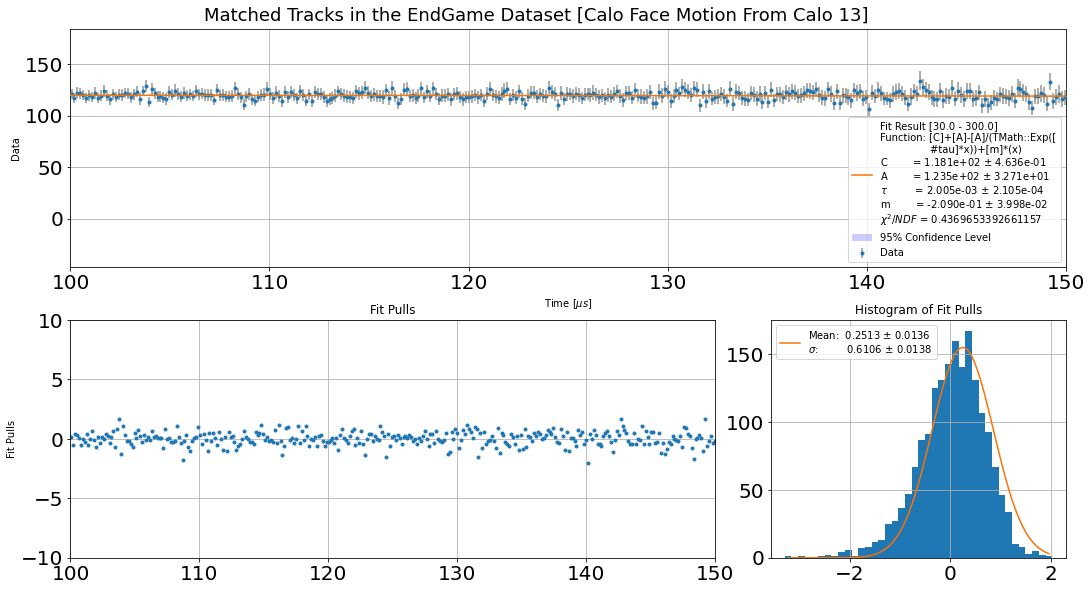

In [259]:
fig,ax = fitresult.draw("Matched Tracks in the "+dataset+" Dataset [Calo Face Motion From Calo "+str(calo)+"]", 
                        yrange=[None, [-10,10]], fmti=".")
#ax[0].set_ylim(-2,2)
#ax[0].set_xlim(0,50)
for i in range(2):
    ax[i].set_xlim(100,150)
ax[0].set_xlabel(r"Time [$\mu s$]")


plt.show()

---

# Now lets compare the fit results from these datasets

In [260]:
print(allFitResults)

{'tracks_beam': <python_fit.fitVector object at 0x7f6d16936990>, 'tracks_calo': <python_fit.fitVector object at 0x7f6d17f411d0>, 'tracks_calo_noRadialField': <python_fit.fitVector object at 0x7f6d16090c90>, 'clusters_calo': <python_fit.fitVector object at 0x7f6d16391910>, 'matchedTracks_beam': <python_fit.fitVector object at 0x7f6cfa081990>, 'matchedTracks_calo': <python_fit.fitVector object at 0x7f6d161380d0>, 'matchedTracks_calo_noRadialField': <python_fit.fitVector object at 0x7f6d180bba10>, 'matchedTracks_clusters': <python_fit.fitVector object at 0x7f6d0a5d7f90>}


In [264]:
pars = []
parErrs = []
fitnames = []
allNames = []

for name,fit in allFitResults.items():
    print(name)
    fitnames.append(name)
    pars.append(fit.pars)
    parErrs.append(fit.parErrs)
    allNames.append( fit.parNames() )
print(allNames)

tracks_beam
tracks_calo
tracks_calo_noRadialField
clusters_calo
matchedTracks_beam
matchedTracks_calo
matchedTracks_calo_noRadialField
matchedTracks_clusters
[['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'm'], ['C', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm'], ['C', 'A', '$\\tau$ ', 'm']]


In [270]:
parDict = {}
histNames = {}
for names in allNames:
    for name in names:
        parDict[name] = []
        histNames[name] = []
for i, names in enumerate(allNames):
    for j, name in enumerate(names):
        parDict[name].append( pars[i][j] )
        histNames[name].append(fitnames[i])

In [271]:
print(parDict)
print(histNames)

{'C': [17.432892610058307, 31.5972695248955, 72.30123207864905, 27.70607470799402, 17.432892610058307, 31.5972695248955, 71.89464227236925, 118.07711018613891], 'A': [-4.666738662255172, 2.486026091847933, -4.666738662255172, 2.486026091847933, 124.18545828084734, 123.53957099768823], '$\\tau$ ': [0.03622335951863845, 0.007759640920492743, 0.03622335951863845, 0.007759640920492743, 0.0006636217829100897, 0.0020048171018296765], 'm': [0.0005611923749928758, -0.0028021661674685963, 0.004246074628943617, 0.00016169161928574461, 0.0005611923749928758, -0.0028021661674685963, -0.07018591683701837, -0.20902885589654965]}
{'C': ['tracks_beam', 'tracks_calo', 'tracks_calo_noRadialField', 'clusters_calo', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField', 'matchedTracks_clusters'], 'A': ['tracks_beam', 'tracks_calo', 'matchedTracks_beam', 'matchedTracks_calo', 'matchedTracks_calo_noRadialField', 'matchedTracks_clusters'], '$\\tau$ ': ['tracks_beam', 'tracks_calo', '

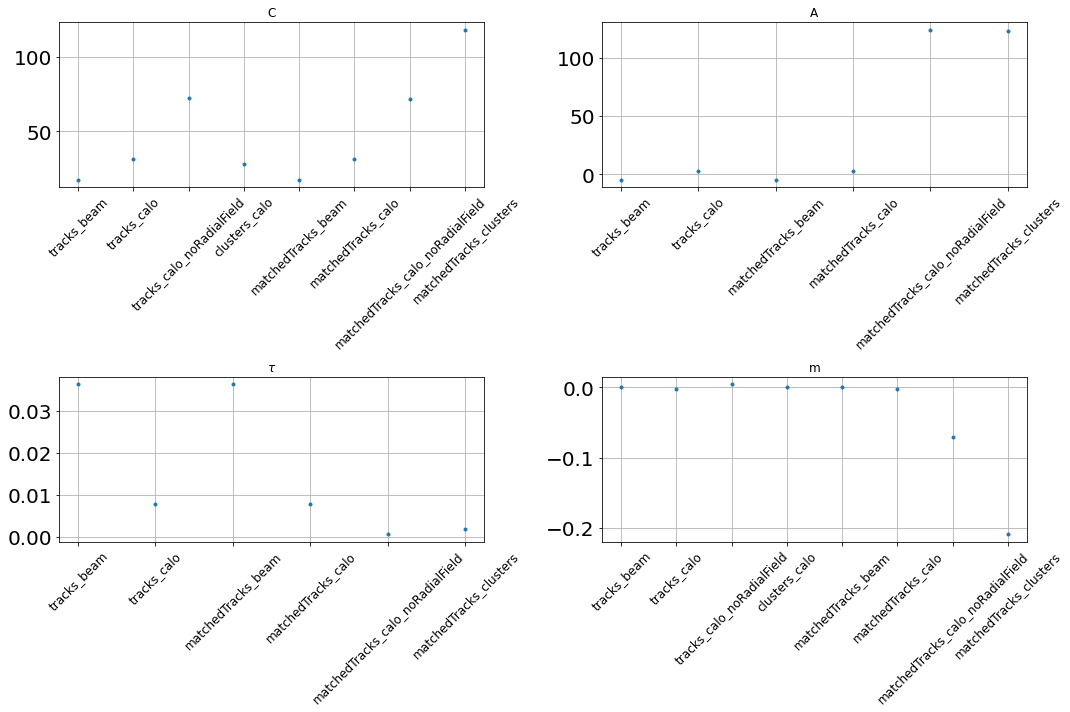

In [282]:
fig,axs = plt.subplots(int(len(parDict)/2),2,figsize=(15,10), sharex=False)
if(len(parDict) > 2):
    ax = flatten2dArray(axs)
else:
    ax = axs

for i, name in enumerate(parDict):
    axi = ax[i]
    thispar = parDict[name]
    axi.plot(histNames[name], thispar,".")
    axi.grid()
    axi.set_title(name)
    plt.sca(axi)
    plt.xticks(rotation=45, fontsize=12,)
plt.tight_layout()
plt.show()